In [1]:
from numpy.random import seed
import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Number of samples we will have in each class.
SAMPLE_SIZE = 260

# The images will all be resized to this size.
IMAGE_SIZE = 96

# Number of channels 
Channels = 3 

# Batch Size
batch_size=40

In [3]:
# Get a list of image folders
folder_path = os.listdir('../input/v2-plant-seedlings-dataset')
print(folder_path)

['Scentless Mayweed', 'Common wheat', 'nonsegmentedv2', 'Charlock', 'Black-grass', 'Sugar beet', 'Loose Silky-bent', 'Maize', 'Cleavers', 'Common Chickweed', 'Fat Hen', 'Small-flowered Cranesbill', 'Shepherd’s Purse']


In [4]:
total_images = 0

# loop through each folder
for folder in folder_path:
    # set the path to a folder
    path = '../input/v2-plant-seedlings-dataset/' + str(folder)
    # get a list of images in that folder
    images_list = os.listdir(path)
    # get the length of the list
    num_images = len(images_list)
    
    total_images = total_images + num_images
    # print the result
    print(str(folder) + ':' + ' ' + str(num_images))
    
print('\n')
# print the total number of images available
print('Total Images: ', total_images)
    

Scentless Mayweed: 607
Common wheat: 253
nonsegmentedv2: 12
Charlock: 452
Black-grass: 309
Sugar beet: 463
Loose Silky-bent: 762
Maize: 257
Cleavers: 335
Common Chickweed: 713
Fat Hen: 538
Small-flowered Cranesbill: 576
Shepherd’s Purse: 274


Total Images:  5551


In [5]:
sdir=r'../input/v2-plant-seedlings-dataset'
classlist=os.listdir(sdir)    
filepaths=[]
labels=[]    
for sinif in classlist:
    if sinif != 'nonsegmentedv2':
        classpath=os.path.join(sdir,sinif)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)        
            for f in flist:
                fpath=os.path.join(classpath,f)        
                filepaths.append(fpath)
                labels.append(sinif)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)    
print (df.head())
print('df length: ', len(df))
print (df['labels'].value_counts())

                                           filepaths             labels
0  ../input/v2-plant-seedlings-dataset/Scentless ...  Scentless Mayweed
1  ../input/v2-plant-seedlings-dataset/Scentless ...  Scentless Mayweed
2  ../input/v2-plant-seedlings-dataset/Scentless ...  Scentless Mayweed
3  ../input/v2-plant-seedlings-dataset/Scentless ...  Scentless Mayweed
4  ../input/v2-plant-seedlings-dataset/Scentless ...  Scentless Mayweed
df length:  5539
Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherd’s Purse             274
Maize                        257
Common wheat                 253
Name: labels, dtype: int64


In [6]:
df['labels'].value_counts()

Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherd’s Purse             274
Maize                        257
Common wheat                 253
Name: labels, dtype: int64

In [7]:
train_split=.8
valid_split=.1

dummy_split = valid_split/(1-train_split)
train_df, dummy_df =train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df),'  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  4431   test_df length:  554   valid_df length:  554


In [8]:
img_shape=(IMAGE_SIZE, IMAGE_SIZE, Channels)
img_size=(IMAGE_SIZE, IMAGE_SIZE)
length=len(test_df)

test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

datagen = ImageDataGenerator(rescale=1.0/255)

train_gen= datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', 
                                                   target_size=img_size, class_mode='categorical',
                                                   color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen= datagen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', 
                                                   target_size=img_size, class_mode='categorical',
                                                   color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen= datagen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', 
                                                    target_size=img_size, class_mode='categorical',
                                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test batch size:  2   test steps:  277
Found 4431 validated image filenames belonging to 12 classes.
Found 554 validated image filenames belonging to 12 classes.
Found 554 validated image filenames belonging to 12 classes.


In [9]:
num_train_samples = len(train_df)
num_val_samples = len(valid_df)

train_steps = np.ceil(num_train_samples / 10)
val_steps = np.ceil(num_val_samples / 10)

In [10]:
df.shape

(5539, 2)

In [11]:
k_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dout_conv = 0.3
dout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, k_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, k_size, activation = 'relu'))
model.add(Conv2D(first_filters, k_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dout_conv))

model.add(Conv2D(second_filters, k_size, activation ='relu'))
model.add(Conv2D(second_filters, k_size, activation ='relu'))
model.add(Conv2D(second_filters, k_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dout_conv))

model.add(Conv2D(third_filters, k_size, activation ='relu'))
model.add(Conv2D(third_filters, k_size, activation ='relu'))
model.add(Conv2D(third_filters, k_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dout_dense))
model.add(Dense(12, activation = "softmax"))

model.summary()

2022-10-29 00:02:24.763292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        3

2022-10-29 00:02:24.937529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 00:02:24.938533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 00:02:24.940514: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-29 00:02:24.940947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# Train the Model

In [12]:
model.compile(Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## Callbacks

In [13]:
filepath = "/kaggle/working/Best_model.h5"

checkpoint = ModelCheckpoint(filepath='/kaggle/working/Best_model.h5', monitor='val_loss', verbose=0, 
                             save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_loss', patience=2,  
                           mode='auto', 
                           restore_best_weights=True)
                                 
callbacks_list = [checkpoint, reduce_lr]


# Model Fitting

In [14]:
 history = model.fit(train_gen,
                    validation_data=valid_gen,
                    epochs=40,
                    callbacks=callbacks_list)

2022-10-29 00:02:28.659754: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-10-29 00:02:31.159895: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


111/111 [==============================] - 84s 684ms/step - loss: 2.4279 - accuracy: 0.1377 - val_loss: 2.4277 - val_accuracy: 0.1354
Epoch 2/40
111/111 [==============================] - 44s 390ms/step - loss: 2.3954 - accuracy: 0.1467 - val_loss: 2.3159 - val_accuracy: 0.2058
Epoch 3/40
111/111 [==============================] - 44s 397ms/step - loss: 1.9184 - accuracy: 0.3304 - val_loss: 1.6139 - val_accuracy: 0.4152
Epoch 4/40
111/111 [==============================] - 44s 401ms/step - loss: 1.6311 - accuracy: 0.4198 - val_loss: 1.4607 - val_accuracy: 0.4603
Epoch 5/40
111/111 [==============================] - 45s 403ms/step - loss: 1.4883 - accuracy: 0.4717 - val_loss: 1.3220 - val_accuracy: 0.5253
Epoch 6/40
111/111 [==============================] - 44s 398ms/step - loss: 1.3741 - accuracy: 0.5200 - val_loss: 1.2401 - val_accuracy: 0.5686
Epoch 7/40
111/111 [==============================] - 44s 397ms/step - loss: 1.2516 - accuracy: 0.5595 - val_loss: 1.1166 - val_accuracy: 0.6

In [15]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [16]:
# Print the validation loss and accuracy.


result_val_acc = model.evaluate(test_gen)

print('val_loss:', result_val_acc[0])
print('val_acc:', result_val_acc[1] * 100)

277/277 [==============================] - 9s 31ms/step - loss: 0.6108 - accuracy: 0.8159
val_loss: 0.6107849478721619
val_acc: 81.58844709396362


<Figure size 432x288 with 0 Axes>

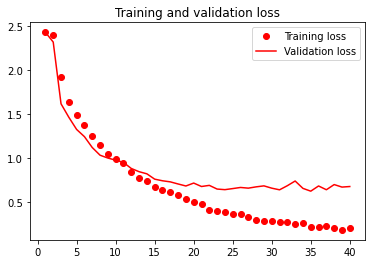

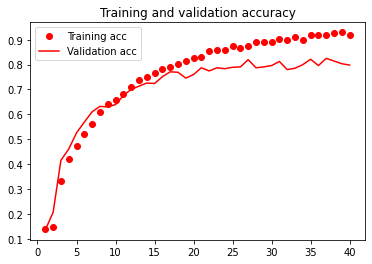

<Figure size 432x288 with 0 Axes>

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [18]:
# make a prediction
predictions = model.predict(test_gen, steps=len(valid_df), verbose=1)

554/554 [==============================] - 6s 10ms/step


In [19]:
predictions.shape

(554, 12)

In [20]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherd’s Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [21]:
# Put the predictions into a dataframe.
# The columns need to be ordered to match the output of the previous cell

class_dict = train_gen.class_indices

# Get a list of the dict keys.
cols = class_dict.keys()

df_preds = pd.DataFrame(predictions, columns=cols)

df_preds.head()


,Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherd’s Purse,Small-flowered Cranesbill,Sugar beet
0,1.461207e-06,5.496627e-03,6.018733e-02,1.034867e-02,1.511245e-05,0.001400,0.000048,2.044087e-02,7.504807e-01,1.669182e-02,1.343107e-01,5.792254e-04
1,4.061153e-01,2.325089e-08,6.855198e-07,2.210529e-06,1.815069e-02,0.000026,0.575691,6.774201e-07,1.227688e-05,5.353680e-09,6.974619e-08,1.126644e-06
2,5.271645e-07,9.631393e-08,8.285544e-10,3.321918e-06,1.551962e-08,0.004649,0.000001,2.547309e-08,8.918518e-07,5.825243e-09,8.746006e-06,9.953361e-01
3,1.682457e-01,1.581233e-09,1.032867e-08,4.102850e-07,1.218445e-03,0.000019,0.830515,1.525415e-07,9.748902e-07,5.204099e-10,7.621231e-09,2.724616e-07
4,7.209878e-02,4.329302e-11,2.474236e-10,8.248227e-08,2.130311e-04,0.000119,0.927569,1.665538e-07,1.053482e-08,6.874177e-12,2.348069e-08,8.618261e-10


In [22]:
df_preds.shape

(554, 12)

In [23]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [24]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    # set the size of the figure here
    plt.figure(figsize=(15,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=80) # set x-axis text angle here
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [25]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[ 0  0  1  0  2  1 31  0  0  0  0  1]
 [ 0 35  0  0  0  0  0  0  0  0  0  1]
 [ 0  0 29  0  0  0  0  0  0  0  1  1]
 [ 0  0  0 76  0  1  0  0  1  2  1  2]
 [ 1  0  0  0 19  0  2  2  0  1  0  0]
 [ 0  1  1  0  2 48  2  0  0  0  0  0]
 [ 3  0  0  0  0  3 68  0  2  0  0  0]
 [ 0  1  0  3  0  0  0 18  1  0  0  2]
 [ 1  0  2  2  1  0  4  0 60  4  1  1]
 [ 0  0  1  2  0  0  0  0  2 27  0  0]
 [ 0  1  1  0  0  0  0  0  0  0 40  0]
 [ 0  0  0  3  0  1  0  1  1  0  0 32]]


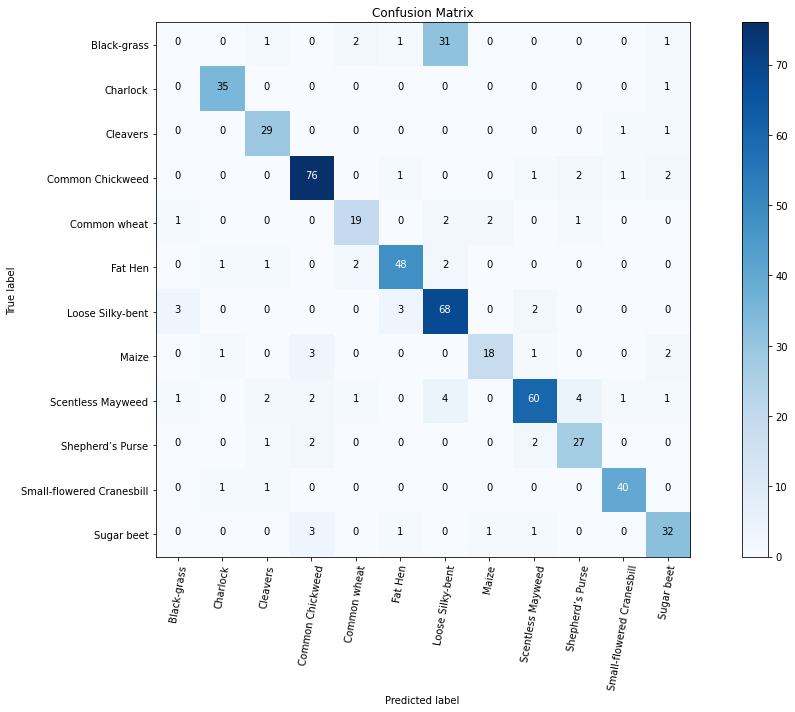

In [26]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = cols

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [27]:
# Generate a classification report
# Get the true labels
y_true = test_gen.classes

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        36
                 Charlock       0.92      0.97      0.95        36
                 Cleavers       0.83      0.94      0.88        31
         Common Chickweed       0.88      0.92      0.90        83
             Common wheat       0.79      0.76      0.78        25
                  Fat Hen       0.89      0.89      0.89        54
         Loose Silky-bent       0.64      0.89      0.74        76
                    Maize       0.86      0.72      0.78        25
        Scentless Mayweed       0.90      0.79      0.84        76
         Shepherd’s Purse       0.79      0.84      0.82        32
Small-flowered Cranesbill       0.93      0.95      0.94        42
               Sugar beet       0.80      0.84      0.82        38

                 accuracy                           0.82       554
                macro avg       0.77      0.79      0.78    